<font size="3">**1. 导包**</font>

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:
print(torch.__version__)

2.5.1


<font size="3">**2. 数据读取**</font>

通过对数据集的观察，文本的首行"Subject:xxx"为邮件标题，从第二行起为邮件正文。这里将标题从文本中单独提取作为一列。

In [3]:
def getemail(folder_path):
    # 初始化一个空列表，用来存放每封邮件的标题和正文
    emails = []
    # 遍历文件夹中的所有txt文件
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            # 尝试用 utf-8 编码打开文件，如果失败则用 latin-1 编码
            try:
                with open(file_path, "r", encoding="utf-8") as file:
                    lines = file.readlines()
            except UnicodeDecodeError:
                with open(file_path, "r", encoding="latin-1") as file:
                    lines = file.readlines()
            
            # 获取邮件标题 (第一行)
            subject = lines[0].strip().replace("Subject:", "").strip()
            
            # 获取邮件正文（从第二行开始）
            body = "".join(lines[1:]).strip()
            
            # 将邮件标题和正文加入列表
            emails.append([subject, body])
    
    # 将列表转换为DataFrame
    df = pd.DataFrame(emails, columns=["title", "body"])
    return df

In [4]:
ham_path = r'D:\研究生\研一\机器学习与神经网络导论\code\enron2\enron2\ham'
spam_path = r'D:\研究生\研一\机器学习与神经网络导论\code\enron2\enron2\spam'

ham_df = getemail(ham_path)
spam_df = getemail(spam_path)

In [5]:
ham_df['label'] = 0
spam_df['label'] = 1
df = pd.concat([ham_df, spam_df], axis = 0)
df = df.reset_index(drop = True)

In [6]:
df.head(10)

,title,body,label
0,re : rankings,thank you .,0
1,re : visit to enron,"vince ,\ndec . 29 at 9 : 00 will be fine . i h...",0
2,research group move to the 19 th floor,hello all :\nin case any of you feel energetic...,0
3,christmas baskets,the christmas baskets have been ordered .\nwe ...,0
4,japan candidate,"vince ,\ni spoke with whalley at the sa offsit...",0
5,christmas break,fyi\n- - - - - - - - - - - - - - - - - - - - -...,0
6,christmas - near,good morning all . we apologize that we are no...,0
7,stentofon,"goodmorning liz ,\nwe are in need of another s...",0
8,re : new color printer,monday will be perfect !\nlocation - ebl 944 b...,0
9,re : new color printer,this is the color printer that is being ordere...,0


In [7]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:2], df.iloc[:,2], test_size=0.2, random_state=24)

<font size="3">**3. 文本处理**</font>

按照词袋模型将文本转换成词向量，并且去除了停用词。

In [8]:
def vectorizer(X_train, X_test, min_df=0.0, max_df=1.0, max_features=64, method='count'):
    '''
    对正文部分进行特征提取，两种方法：count不考虑词频，term_frequency考虑词频
    '''
    if method == 'count':
        vectorizer = CountVectorizer(
            min_df=min_df, max_df=max_df, max_features=max_features, stop_words='english')
    elif method == 'term_frequency':
        vectorizer = TfidfVectorizer(
            min_df=min_df, max_df=max_df, max_features=max_features, ngram_range=(1, 1), stop_words='english')
    
    features_train = vectorizer.fit_transform(X_train).toarray()
    features_test = vectorizer.transform(X_test).toarray()
    features_name = vectorizer.get_feature_names_out()
 
    return features_name, features_train, features_test

In [9]:
title_vec_name, X_train_title_vec, X_test_title_vec = vectorizer(X_train['title'], X_test['title'], max_features = 64)
body_vec_name, X_train_body_vec, X_test_body_vec = vectorizer(X_train['body'], X_test['body'], max_features = 256)

In [10]:
#转化为张量表示
X_train_ts = torch.from_numpy(np.hstack((X_train_title_vec, X_train_body_vec))).float()
X_test_ts = torch.from_numpy(np.hstack((X_test_title_vec, X_test_body_vec))).float()

y_train_ts = torch.from_numpy(y_train.to_numpy()).unsqueeze(1).float()
y_test_ts = torch.from_numpy(y_test.to_numpy()).float()

In [11]:
X_train_ts.shape

torch.Size([4685, 320])

In [12]:
y_train_ts.shape

torch.Size([4685, 1])

<font size="3">**4. 构造变分贝叶斯网络**</font>

4.1 贝叶斯线性层

In [13]:
# BNN层，类似于BP网络的Linear层，与BP网络类似，一层BNN层由weight和bias组成，weight和bias都具有均值和方差
class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        # 从标准正态分布中采样权重
        w_epsilon = Normal(0,1).sample(self.w_mu.shape)
        # 获得服从均值为mu，方差为delta的正态分布的样本
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        # 与sample weights同理
        b_epsilon = Normal(0,1).sample(self.b_mu.shape)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        # 计算log p(w)，用于后续计算loss
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        # 计算 log p(w|\theta)，用于后续计算loss
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()

        # 权重确定后，和BP网络层一样使用
        return F.linear(input, self.w, self.b)

4.2 贝叶斯网络（包含一个隐藏层）

In [14]:
class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        # 输出为1，只含有一层隐藏层的BNN
        self.hidden = Linear_BBB(320, hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        # 激活函数选用sigmoid
        x = torch.sigmoid(self.hidden(x))
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden.log_post + self.out.log_post

    # 计算ELBO
    def sample_elbo(self, input, target, samples):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0])
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples

        # 蒙特卡罗近似
        for i in range(samples):
            outputs[i] = self(input).reshape(-1) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss

<font size="3">**5. 模型训练与评估**</font>

In [15]:
torch.cuda.manual_seed(2410)
torch.cuda.manual_seed_all(2410)

elbos = []
net = MLP_BBB(128, prior_var=0.2)
optimizer = optim.Adam(net.parameters(), lr=0.1)
epochs = 6000
for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = net.sample_elbo(X_train_ts, y_train_ts, 1)
    loss.backward()
    optimizer.step()
    elbos.append(loss.item())  # 记录每个epoch的损失
    if epoch % 100 == 0:
        print('epoch: {}/{}'.format(epoch+1,epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/6000
Loss: 4686844.5
epoch: 101/6000
Loss: 967771.75
epoch: 201/6000
Loss: 486042.65625
epoch: 301/6000
Loss: 575192.75
epoch: 401/6000
Loss: 271949.15625
epoch: 501/6000
Loss: 308726.84375
epoch: 601/6000
Loss: 157605.109375
epoch: 701/6000
Loss: 122423.4453125
epoch: 801/6000
Loss: 99513.6328125
epoch: 901/6000
Loss: 84664.6953125
epoch: 1001/6000
Loss: 73684.125
epoch: 1101/6000
Loss: 62346.53125
epoch: 1201/6000
Loss: 47456.51171875
epoch: 1301/6000
Loss: 48310.796875
epoch: 1401/6000
Loss: 38780.20703125
epoch: 1501/6000
Loss: 37942.890625
epoch: 1601/6000
Loss: 31189.072265625
epoch: 1701/6000
Loss: 28732.03515625
epoch: 1801/6000
Loss: 25154.669921875
epoch: 1901/6000
Loss: 24733.109375
epoch: 2001/6000
Loss: 21115.6015625
epoch: 2101/6000
Loss: 28893.7265625
epoch: 2201/6000
Loss: 19170.037109375
epoch: 2301/6000
Loss: 17018.720703125
epoch: 2401/6000
Loss: 16069.6943359375
epoch: 2501/6000
Loss: 15814.8154296875
epoch: 2601/6000
Loss: 31594.638671875
epoch: 2701/6000


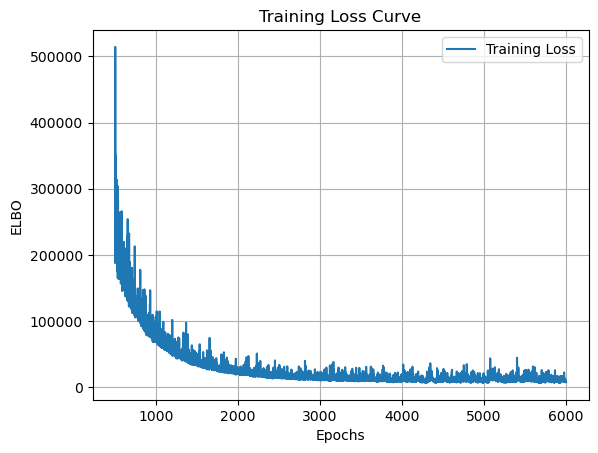

In [16]:
plt.plot(range(500, epochs), elbos[500:], label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# 对测试集进行预测
net.eval()
with torch.no_grad():
    y_pred = net(X_test_ts).squeeze()  # 模型预测的概率值
    y_pred_label = (y_pred > 0.5).float()  # 通过0.5的阈值将概率转为标签

# 计算准确率
correct = (y_pred_label == y_test_ts).sum().item()
accuracy = correct / len(y_test_ts)  # 计算准确率
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9812


Precision: 0.9544
Recall: 0.9734
F1 Score: 0.9638


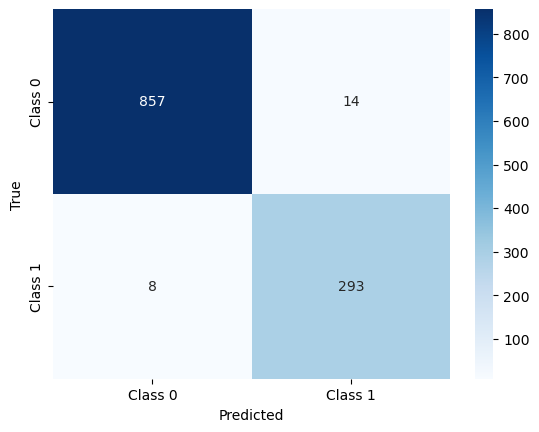

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
# 计算精确度、召回率和 F1 分数
precision = precision_score(y_test_ts.numpy(), y_pred_label.numpy())
recall = recall_score(y_test_ts.numpy(), y_pred_label.numpy())
f1 = f1_score(y_test_ts.numpy(), y_pred_label.numpy())

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test_ts.numpy(), y_pred_label.numpy())

# 可视化混淆矩阵
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<font size="3">**6. 种子敏感性实验**</font>

In [20]:
seeds = [42, 86, 123, 628, 999, 1001, 5002, 8428, 10000, 10024]
results = []

for seed in seeds:
    # 设置随机种子
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # 执行模型训练
    model = MLP_BBB(128, prior_var=0.2)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    epochs = 6000
    for epoch in range(epochs): 
        optimizer.zero_grad()
        loss = model.sample_elbo(X_train_ts, y_train_ts, 1)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_ts).squeeze()
        y_pred_label = (y_pred > 0.5).float()
    correct = (y_pred_label == y_test_ts).sum().item()
    accuracy = correct / len(y_test_ts)
    results.append(accuracy)

print("Results from different seeds:", results)

Results from different seeds: [0.9598976109215017, 0.9761092150170648, 0.9761092150170648, 0.9633105802047781, 0.9735494880546075, 0.9761092150170648, 0.9744027303754266, 0.9744027303754266, 0.976962457337884, 0.9556313993174061]


<font size="3">**7. 消融实验：先验方差的敏感性分析**</font>

In [21]:
torch.cuda.manual_seed(2410)
torch.cuda.manual_seed_all(2410)

vars = [0.1, 0.5, 1, 5, 10]
results2 = []

for var in vars:
    model = MLP_BBB(128, prior_var=var)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    epochs = 6000
    for epoch in range(epochs): 
        optimizer.zero_grad()
        loss = model.sample_elbo(X_train_ts, y_train_ts, 1)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_ts).squeeze()
        y_pred_label = (y_pred > 0.5).float()
    correct = (y_pred_label == y_test_ts).sum().item()
    accuracy = correct / len(y_test_ts)
    results2.append(accuracy)

print("Results from different seeds:", results2)

Results from different seeds: [0.9701365187713311, 0.9752559726962458, 0.9803754266211604, 0.9718430034129693, 0.9778156996587031]
